<a href="https://colab.research.google.com/github/viswanath-kasireddy/CS370/blob/main/RoleRedefinition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plot
%matplotlib inline
from math import log2
from sklearn import tree 
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import graphviz
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [112]:
df_p = pd.read_html('https://www.basketball-reference.com/leagues/NBA_2021_per_game.html#per_game_stats')[0]
df_a = pd.read_html('https://www.basketball-reference.com/leagues/NBA_2021_advanced.html#advanced_stats')[0]
df_s = pd.read_csv('https://raw.githubusercontent.com/viswanath-kasireddy/CS370/main/ShootingStats.csv')
df_p = df_p[df_p['Rk']!='Rk']
df_a = df_a[df_a['Rk']!='Rk']
df_p = df_p.drop(['Rk','Age','Unnamed: 30','Unnamed: 31', 'Tm', 'Pos', 'G', 'GS'], axis=1, errors='ignore')
df_s = df_s.drop(['Rk', 'Age','Pos','Tm','Player','G','MP'],axis = 1,errors = 'ignore')
df_a = df_a.drop(['Rk', 'Age', 'Pos', 'Tm', 'Unnamed: 19', 'Unnamed: 24','Player','G','MP'], axis=1, errors ='ignore')
#df_s = df_s.drop(['Unnamed: 0_level_0'])
df_a.reset_index(drop=True, inplace=True)
df_s.reset_index(drop=True, inplace=True)
df_p.reset_index(drop=True, inplace=True)
total = pd.concat([df_p,df_a,df_s],axis = 1)
for col in total.columns:
  if(col != 'Player'):
    total[col] = total[col].astype(float)
total = total[total.MP>=15]
#index_names = total[total['MP']<=15].index
#df_c.drop(index_names, inplace= True)
#df_c.drop(columns=['MP'],axis = 1, inplace = True)
#df_c
total = total.drop_duplicates()
total.fillna(0,inplace=True)
players = total['Player']
total.drop(columns=['Player'],axis = 1, inplace = True)
total = (total - total.mean())/total.std()
for col in total.columns:
  if(col != 'Player'):
    total[col] = total[col].astype(float)
total

,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,FG%,Dist.,2P,0-3,3-10ft,10-16ft,16-3P,3P,2P.1,0-3.1,3-10ft.1,10-16ft.1,16-3P.1,3P.1,2P.2,3P.2,%FGA,dunkno,%3PAC,3P%C
2,0.504413,-0.415068,-0.873597,1.996673,-1.426964,-1.539077,-3.130217,0.219267,-0.073338,1.287787,1.255665,-0.544248,0.033701,-2.589097,3.478629,0.978565,1.902018,-0.365605,0.341851,0.463400,-0.090029,-0.080867,-0.642284,0.195466,0.568713,-1.900769,1.580227,2.847846,0.803218,1.670591,-0.655051,0.132644,0.219335,1.365310,-1.379708,0.600338,0.675058,0.690040,0.479931,0.132621,-0.177040,0.044615,-0.040588,1.996673,-2.143205,1.900762,2.417961,1.009470,-0.287808,-1.208164,-1.900769,1.287787,0.335503,0.810139,0.327375,-1.873791,-3.130217,0.329629,-3.206279,1.396068,1.106161,-1.458412,-2.068037
3,1.459602,1.386747,0.791969,1.431610,-1.426964,-1.539077,-0.730103,2.322402,2.089362,0.696769,0.624153,1.938117,1.957740,0.248280,1.564421,1.841466,1.944970,1.503231,1.195271,1.157028,1.545722,0.570215,1.248866,1.765338,1.043087,-1.900769,1.620775,0.940963,1.158429,1.203104,1.355425,0.305227,0.832433,0.734413,0.797987,2.517939,2.505876,2.780131,1.714041,1.313986,1.788839,1.787826,2.690409,1.431610,-1.348853,1.900762,0.547650,1.314665,2.232628,0.847028,-1.900769,0.696769,1.301736,0.596901,0.482471,0.243175,-0.730103,0.618605,0.743580,1.465251,4.112883,-0.711671,-2.068037
4,0.207975,0.580672,0.537507,0.185901,-0.084554,-0.197902,0.594759,0.717378,0.840479,-0.158320,-0.051418,-0.106183,-0.266930,0.831741,-0.349787,0.173191,0.012129,-0.365605,-1.080516,1.388238,-0.467510,-0.243637,0.362922,0.319404,-0.063787,-0.618596,-0.682314,-0.396701,0.060504,-0.110314,-0.440449,-1.248022,1.138982,-1.057336,0.525775,-0.445627,-0.667543,-0.572722,-0.137123,0.169539,-0.095129,0.108004,-0.304878,0.185901,0.347196,0.618587,-0.735396,-0.731273,1.060705,4.471640,-0.618596,-0.158320,-0.343730,0.606172,0.413539,0.808065,0.594759,0.778041,0.617184,-0.195137,-0.257352,-0.412975,0.469125
5,0.207975,0.628088,0.630039,0.070319,0.027314,0.025628,0.325947,0.717378,0.810018,-0.108021,-0.154222,-0.179194,-0.266930,0.559992,-0.222173,0.115664,0.012129,-0.472395,-1.080516,0.925819,-0.467510,-0.406407,0.396997,0.195466,-0.237725,-0.460791,-0.763409,-0.311318,-0.004079,-0.154837,-0.530808,-1.420605,0.587194,-1.284459,0.616513,-0.561845,-0.789597,-0.703353,-0.342808,0.169539,-0.586599,-0.082164,-0.392975,0.070319,0.583354,0.460781,-1.009878,-0.652149,0.627255,5.050830,-0.460791,-0.108021,-0.267196,0.290951,0.459494,0.967112,0.325947,0.862741,0.597435,-0.425746,-0.467123,-0.502583,0.398155
6,0.224444,0.391007,0.121116,0.802334,-0.532024,-1.136724,4.550147,0.717378,0.931860,-0.372093,0.506663,0.185860,-0.146677,1.854795,-0.732628,0.518351,0.140985,0.008162,-0.511569,3.931540,0.035798,0.407444,0.243660,0.835809,0.805900,-1.437214,-0.284951,-0.738232,0.383423,0.067776,-0.067721,-0.730272,3.407444,-0.073136,0.108384,-0.619954,-1.155761,-0.877527,0.733082,0.169539,1.788839,0.836984,-0.392975,0.802334,-0.855067,1.437207,0.688083,-1.172111,3.308228,1.519636,-1.437214,-0.372093,-0.448963,3.183571,0.327375,-1.089526,4.550147,0.434258,0.743580,0.980971,-0.467123,0.931159,0.889028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
700,0.191506,-0.130571,-0.179611,0.044635,-0.084554,-0.197902,0.690764,-0.168152,-0.073338,-0.221194,0.110132,-0.471237,-0.567561,0.520029,0.033055,-0.344550,-0.245584,0.542115,2.333165,-0.230228,-0.090029,-1.383029,-0.233387,0.360716,0.046900,-0.130385,-0.674205,0.001752,-0.472312,-0.332927,0.451840,2.548808,-0.332453,0.153987,-0.399745,-0.271299,-0.789597,-0.485635,0.052740,0.317210,0.723988,0.551731,-0.040588,0.044635,-0.253936,0.130374,-0.090681,0.952952,0.113535,-0.96

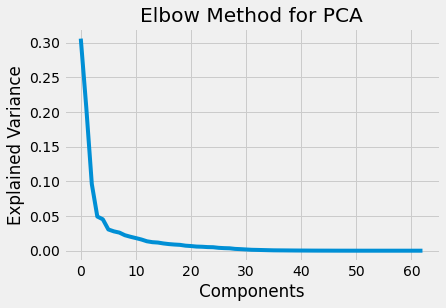

(63,)

In [137]:
#total.dropna
#scaler = StandardScaler()
#std = scaler.fit_transform(total)
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)
clean_dataset(total)
pca = PCA()
pca.fit(total)
plot.style.use("fivethirtyeight")
plot.plot(pca.explained_variance_ratio_)
plot.ylabel('Explained Variance')
plot.xlabel('Components')
plot.title('Elbow Method for PCA')
plot.show()
pca.explained_variance_ratio_.shape

In [126]:
pca = PCA(n_components=5)
pca.fit(total)
scores = pca.transform(total)
scores

array([[ 6.63309229, -7.14310417,  2.0025764 , -0.16259063,  0.09931513],
       [10.98683642,  0.54156804,  1.32921094,  0.94836199,  0.85061038],
       [ 0.03986239,  1.10227987, -0.06536274,  0.07241697, -3.26239245],
       ...,
       [ 5.43094266,  9.03834547,  3.24290261,  1.91427526, -0.6780352 ],
       [ 4.96600033, -5.11903987,  0.41189361,  0.16520496, -1.03288301],
       [ 8.42294405, -6.62759037, -2.13832875,  0.09285845, -1.4535572 ]])

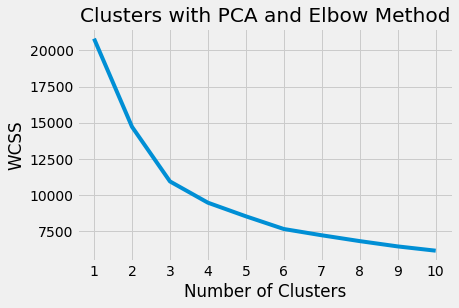

In [139]:
wcss = []
for i in range (1,11):
  kmeans_pca = KMeans(n_clusters=i, init = 'k-means++', random_state = 42)
  kmeans_pca.fit(scores)
  wcss.append(kmeans_pca.inertia_)
wcss
plot.style.use("fivethirtyeight")
plot.plot(range(1,11),wcss)
plot.xticks(range(1, 11))
plot.xlabel('Number of Clusters')
plot.ylabel('WCSS')
plot.title('Clusters with PCA and Elbow Method')
plot.show()

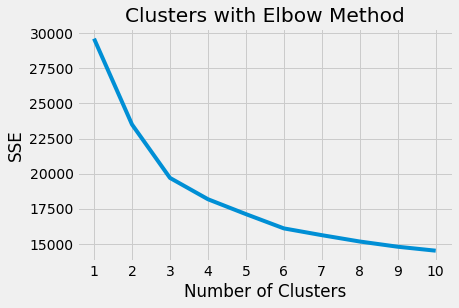

In [141]:
kmeans_kwargs = {"init": "random", "n_init": 10, "max_iter": 300, "random_state": 42,}
sse = []
for k in range(1, 11):
  kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
  kmeans.fit(total)
  sse.append(kmeans.inertia_)
plot.style.use("fivethirtyeight")
plot.plot(range(1, 11), sse)
plot.xticks(range(1, 11))
plot.xlabel("Number of Clusters")
plot.ylabel("SSE")
plot.title("Clusters with Elbow Method")
plot.show()


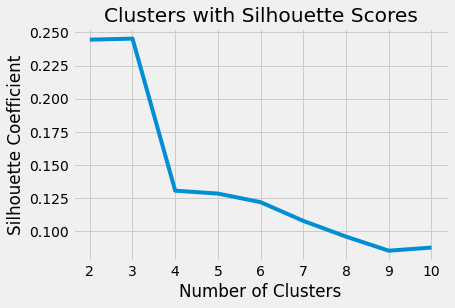

In [143]:
silhouette_coefficients = []
for k in range(2, 11):
   kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
   kmeans.fit(total)
   score = silhouette_score(total, kmeans.labels_)
   silhouette_coefficients.append(score)

plot.style.use("fivethirtyeight")
plot.plot(range(2, 11), silhouette_coefficients)
plot.xticks(range(2, 11))
plot.xlabel("Number of Clusters")
plot.ylabel("Silhouette Coefficient")
plot.title("Clusters with Silhouette Scores")
plot.show()